<a href="https://colab.research.google.com/github/vanessavmac/syde572-intro-to-pattern-recognition/blob/main/syde572_kaggle_nlp_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYDE572 Assignment 4 - NLP Sentiment Classification

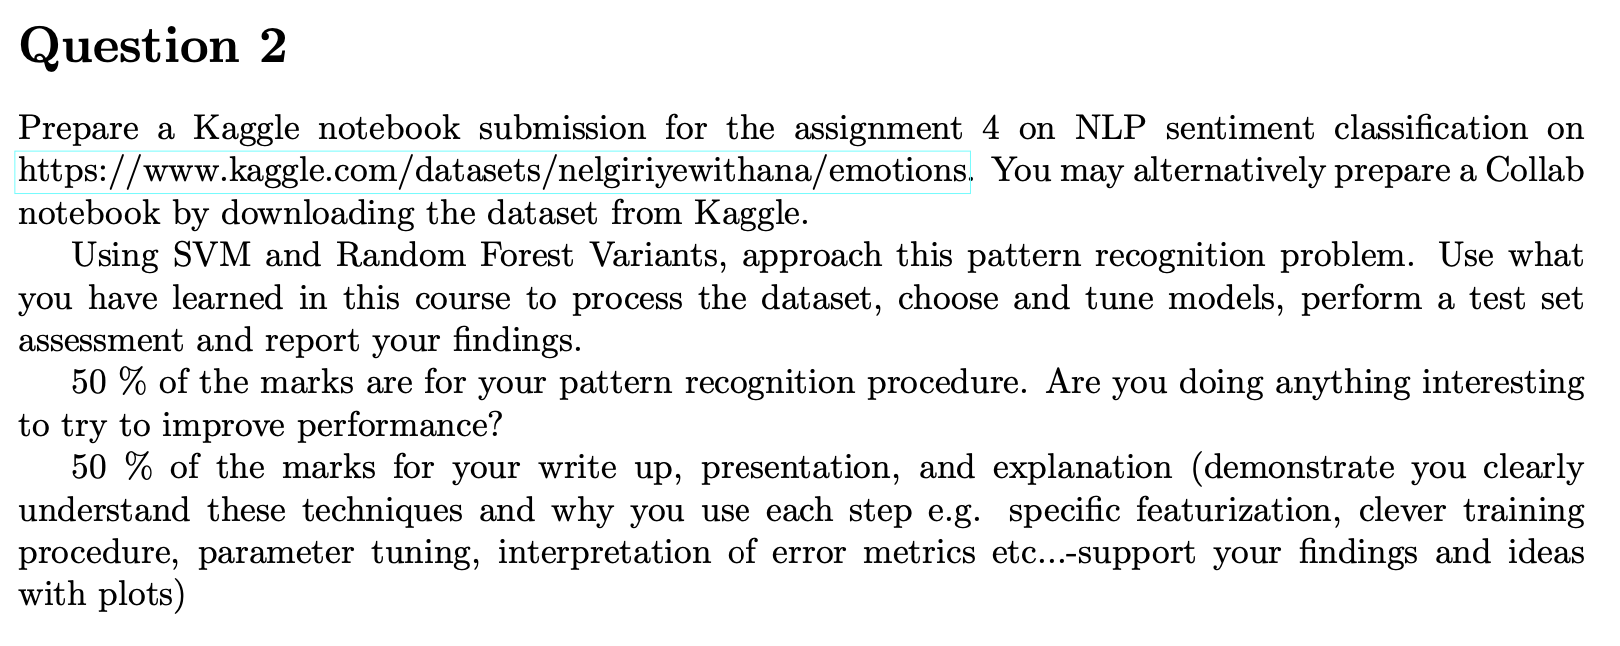

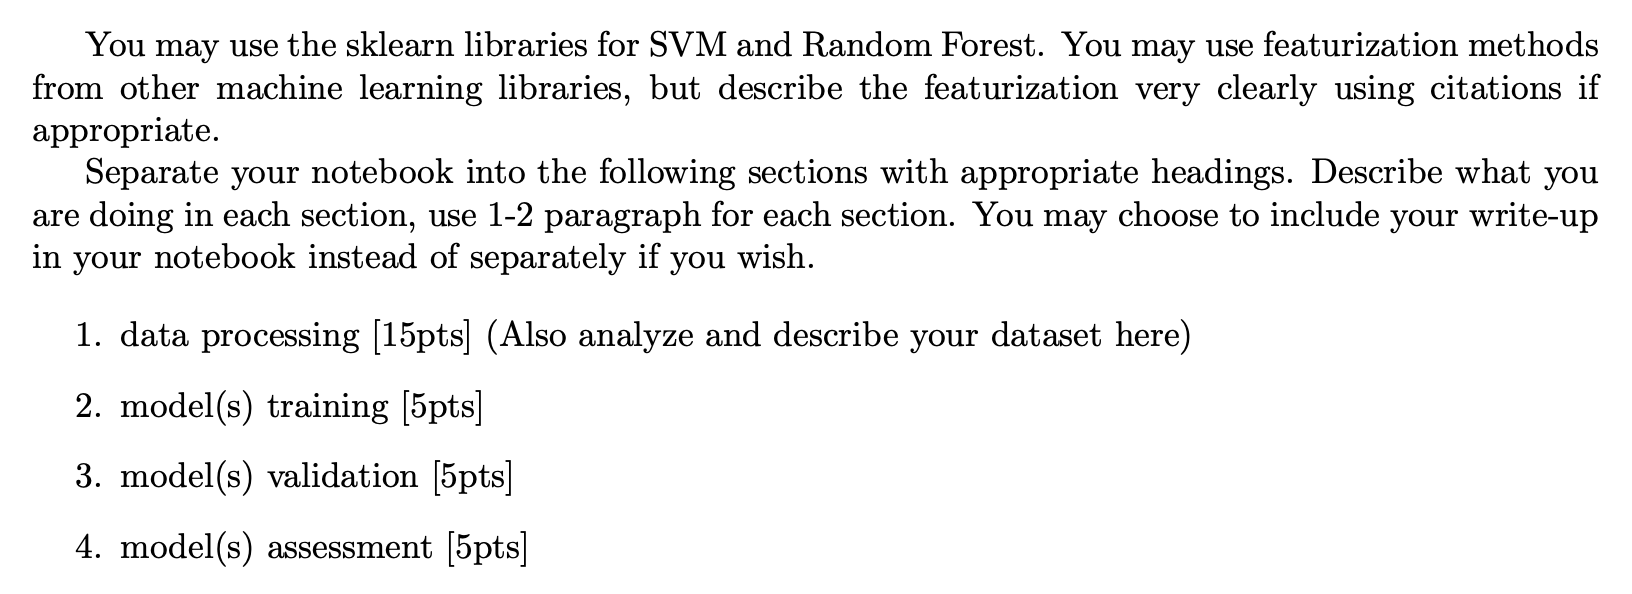

# Import libraries + dataset

In [ ]:
!pip install sentence-transformers
!pip install delayed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import nltk
import joblib
import os
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.metrics import classification_report
import pickle
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

string.punctuation

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/a4"

np.random.seed(1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Analysis and Processing
First part of analysis/processing:
1. Remove duplicate samples
2. Perform data cleaning (detailed steps described in section "Data Cleaning")

In [ ]:
# sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
dataset = pd.read_csv("/content/drive/My Drive/a4/text.csv")
dataset.columns = ['ID', 'text', 'label']
dataset = dataset.drop(columns=['ID'])
print('Datset size: ', dataset.shape)
dataset.head()

Datset size:  (416809, 2)


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
# Remove duplicated samples -- Kaggle says there are 393822 unique values, but dataframe has 416809 samples
dups = dataset[dataset.duplicated(keep=False)]
dataset = dataset.drop_duplicates(subset='text', keep="last")
print('dataset size no duplicates: ', dataset.shape)
dataset.head()

dataset size no duplicates:  (393822, 2)


,text,label
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
5,i was beginning to feel quite disheartened,0


## Data Cleaning

Performed the following data cleaning tasks:
1. Make all text lowercase (letter casing doesn't provide significant information for sentiment analysis).
2. Remove special characters, punctuation, extra white space, numeric values, nonalphanumeric values (not helpful for sentiment analysis).
3. Remove stop-words (words which don't hold significant meaning since they are so common). Instead of using NLTK's full list of stop words `stop_words='english’` which can remove too much vocabulary, a select list of stop words was used. Removing too many stop words reduced performance when tested later with SVM/RandomForest.

The following steps were coded below and tested. However, these steps were not included in the final data processing algorithm since they reduced validation accuracy when tested later with SVM/RandomForest.
4. Following steps 1-3 above, drop samples that are 2 words or less (3 words is required to express feeling usually (e.g. i feel happy). All of these "short" samples were from the majority categories (e.g. 0, 1)
5. Following steps 1-3, apply normalization. Two techniques were tested: stemming and lemmatization. Stemming converts words into their root words, but often results in incorrect meanings/spellings. Lemmatization is like stemming but utilizes the context to return more meaningful representations (lemma). To perform lemmatization, each word's POS tag (part-of-speech tag -- assigns grammatical categories such as noun, verb, adjective, adverb, pronoun, etc to each word). Then WordNet is used to find the matching tag and the NLTK lemmatizer lemmatizes the word based on the tag [[1]](https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258). However, both techniques reduced performance slightly when tested with SVM/RF and were excluded from the final algorithm.

In [ ]:
# remove urls
dataset['text_cleaned'] = dataset['text'].str.replace(r'http\S+', '', regex=True)
# remove special characters and punctuation
dataset['text_cleaned'] = dataset['text_cleaned'].str.replace(r'[^\w\s]', '', regex=True)
# remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
dataset['text_cleaned'] = dataset['text_cleaned'].apply(lambda x:remove_punctuation(x))
# remove extra white spaced
dataset['text_cleaned'] = dataset['text_cleaned'].str.replace(r'\s+', ' ', regex=True)
# remove numeric values
dataset['text_cleaned'] = dataset['text_cleaned'].str.replace(r'\d+', '', regex=True)
# lowercase
dataset['text_cleaned'] = dataset['text_cleaned'].str.lower()
# remove nonalpha numeric characters
dataset['text_cleaned'] = dataset['text_cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# remove stop-words
english_stop_words=['in','of','at','a','an','the']
dataset['text_cleaned'] = dataset['text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (english_stop_words)]))

In [ ]:
# EXCLUDED FROM FINAL DATA PROCESSING: Dropping samples decreases accuracy
# drop samples that are 2 words or less (3 words is required to express feeling usually e.g. i feel happy)
problematic_indices = []
problematic_indices_labels = []
for index, row in dataset.iterrows():
  if not row['text_cleaned'] or np.char.count(row['text_cleaned'], ' ') + 1 < 3:
    problematic_indices.append(index)
    problematic_indices_labels.append(row['label'])
    print(row['text_cleaned'], ' >> ' , row['text'])
print('\nRemove this many samples: ', len(problematic_indices))

freq = pd.Series( (v for v in problematic_indices_labels) ).value_counts().sort_index()
print('\nDropped samples class frequencies:')
print(freq)

# dataset = dataset.drop(problematic_indices)

hairdressers  >>  at the hairdressers
death friend  >>  the death of a friend
thinking unknown  >>  thinking of the unknown
while army  >>  while in the army
may th  >>  in may th
before examination  >>  before examination
hostel  >>  at hostel
during interrailtrip  >>  during interrailtrip
murder  >>  a murder
on school  >>  on school
setbacks  >>  at setbacks
utterance  >>  an utterance
before examn  >>  before the examn
rainy day  >>  a rainy day
enrolling varsity  >>  enrolling at varsity
fear thief  >>  fear of thief
sometimes  >>  sometimes
when school  >>  when at school
time when  >>  a time when
before examn  >>  before an examn
child  >>  a child
climbing mountain  >>  climbing a mountain
film  >>  in a film
morning  >>  in the morning
one year  >>  one year
recurrent lovesickness  >>  a recurrent lovesickness
earth crake  >>  earth crake
grovelling people  >>  grovelling people
not applicable  >>  not applicable
friend mine  >>  a friend of mine
relative  >>  a relative
succ

In [ ]:
# EXCLUDED FROM FINAL DATA PROCESS: Normalization decreases accuracy, do not apply lemmatization OR stemming

# normalization (Lemmatization) It stems the word but makes sure that it does not lose its meaning.
# Lemmatization has a pre-defined dictionary based on POS tags that stores the context of words and checks the word in the dictionary while diminishing.
lemmatizer = WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    # function to convert nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# dataset['text_cleaned_lemm'] = dataset['text_cleaned'].apply(lambda x:lemmatize_sentence(x))

stemmer = nltk.PorterStemmer()
def get_stemmed_text(corpus):
    return [' '.join([stemmer.stem(word) for word in text_segment.split()]) for text_segment in corpus]

# dataset['text_cleaned_stemmed'] = get_stemmed_text(dataset['text_cleaned'])


In [ ]:
print(dataset.shape)
dataset.head()

(393822, 3)


,text,label,text_cleaned
1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with dmrg and am feeli...
3,i dont know i feel so lost,0,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,4,i am kindergarten teacher and i am thoroughly ...
5,i was beginning to feel quite disheartened,0,i was beginning to feel quite disheartened


In [ ]:
# EXCLUDED FROM FINAL ALGORITHM: normalization wasn't used since it decreased performance
# check for problematic lemmatizations/stemmed samples
# for index, row in dataset.iterrows():
#   if not row['text_cleaned_lemm'] or not row['text_cleaned_stemmed']:
#     print(index)
#     print(dataset.iloc[index])

In [ ]:
# Save processed dataset for faster loading
# dataset.to_csv('/content/drive/My Drive/a4/processed_dataset_nodropornorm.csv', index=False)

## Data Splitting (80/10/10)

Instead of 60/20/20 data split, I used a larger portion for training since after downsampling the training dataset, there will be a lot less samples. More details described below.

In [ ]:
# Load cleaned dataset from csv to save time (see previous cells "Data Cleaning")
dataset = pd.read_csv("/content/drive/My Drive/a4/processed_dataset_nodrop_nonorm.csv", index_col=False)

In [ ]:
# check for empty strings
print('Remove the following samples, formatted as: text_cleaned >> original_text')
problematic_indices = []
for index, row in dataset.iterrows():
  if not isinstance(row['text_cleaned'], str):
    problematic_indices.append(index)
    print(row['text_cleaned'], ' >> ' , row['text'])
print('Remove this many samples: ', len(problematic_indices))

Remove the following samples, formatted as: text_cleaned >> original_text
nan  >>  in
Remove this many samples:  1


In [ ]:
dataset = dataset.drop(problematic_indices)

class frequencies:
0    118516
1    135114
2     29406
3     54788
4     43616
5     12381
Name: label, dtype: int64


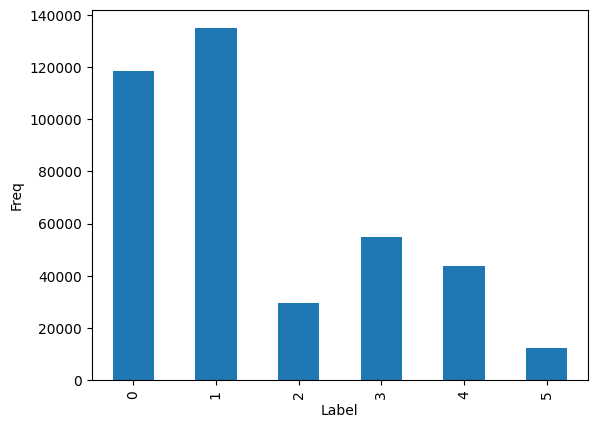

In [ ]:
# Class distributions
freq = dataset['label'].value_counts().sort_index()
print('class frequencies:')
print(freq)

fig, ax = plt.subplots()
freq.plot.bar()
plt.xlabel('Label')
plt.ylabel('Freq')
plt.show()

# class frequencies:
# 0    118516
# 1    135114
# 2     29406
# 3     54788
# 4     43616
# 5     12381
# Name: label, dtype: int64

There is extreme class imbalance and the dataset is extremely large which makes training too long.

----------------------------------------

There are several options to address this if using SVM.
1.   **Don't change class distributions.** This has the benefit of preserving all the information and the class distributions of the dataset. However, this would likely make the model biased towards larger classes. Using this option generally increases training time. If the dataset is left unbalanced, **class weights** can be used during training (see Model(s) training) which applies a cost-sensitive loss function to penalize minority misclassification more.
2.   **Random undersampling of the majority classes can be performed.** For example, class 5 (which has the fewest samples) has 12381 data points compared to class 1 with 135087 samples. 12381 points for class 5 may still be sufficient to train the model, so undersampling the majority classes to match 12381 samples may be more useful. This has the advantage of removing bias but it also risks performance for the majority classes due to data loss.
3.  **(Not used) Random oversampling.** Given that some classes are significantly larger, using upsampling would results in too many duplicates which increases risk of overfitting.
4.   **(Not used) Another potentially useful method for SVM is SMOTE** which synthesizes new samples for the minority classes, which avoids the issue of duplicates in random upsampling. SMOTE does this by drawing a line between closely located examples in the feature space and generating a new sample at a point along that line. However, since this will make the dataset extremely large, significantly increase compute time, and will not guarantee improved performance (risks overfitting by synthesizing new samples based on the minority class), this method was not tested [[2]](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).


----------------------------------------


Random forest utilizes bagging, feature bagging, and ensemble learning. If using random forest, the approaches above could also be used. I tested the following:
1. Random undersampling of majority classes to the size of the minority class 5. Then regular random forest can be used.
2. Don't change class distributions (leave unbalanced).

For the second option, I applied various random forest variants to address the class imbalance. Standard random forest (although it uses bagging and aggregation) is not ideal for extremely unbalanced datasets. The following variants are used [[3]](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/):
1.   Use Random Forest with **class weightings**. When measuring entropy after each split, apply a class weight which places a heavier penalty on misclassifying the minority class.
2.   Use Random Forest with **bootstrapped class weightings**. Each decision tree of a random forest is trained on a bootstrapped dataset. The class weighting can be based on the class distribution in each bootstrap dataset rather than the entire dataset (as done with regular class weights).
3.   Use Random Forest with **random undersampling** via the `BalancedRandomForestClassifier` implementation. This involves randomly undersampling the majority class in each bootstrapped dataset that a tree trains on.
All three methods have similar advantages/disadvantages as described previously due to undersampling, removing data, or requiring more parameters to train. Also training on the entire dataset will increase training time considerably.

### No undersampling (unbalanced) dataset split

Split dataset 80/10/10, keep original unbalanced class distribution.

In [ ]:
# Shuffle
shuffled_dataset = dataset.sample(frac = 1, random_state=0)
samples = shuffled_dataset['text_cleaned'].to_numpy()
labels = shuffled_dataset['label'].to_numpy()

# Split 80, 10, 10
X_train = samples[:int(0.8*np.size(samples))]
X_val = samples[int(0.8*np.size(samples)):int(0.9*np.size(samples))]
X_test = samples[int(0.9*np.size(samples)):]
y_train = labels[:int(0.8*np.size(samples))]
y_val = labels[int(0.8*np.size(samples)):int(0.9*np.size(samples))]
y_test = labels[int(0.9*np.size(samples)):]

print('X_train size: ', np.size(X_train))
print('X_val size: ', np.size(X_val))
print('X_test size: ', np.size(X_test))
print('y_train size: ', np.size(y_train))
print('y_val size: ', np.size(y_val))
print('y_test size: ', np.size(y_test))

print(X_train)
print(y_train)

X_train size:  315056
X_val size:  39382
X_test size:  39383
y_train size:  315056
y_val size:  39382
y_test size:  39383
['i don t really like to shop for most part but when i feel threatened that s when i want to spend'
 'i cant stop feeling heartbroken and lonely'
 'i was nervous i was exhilarated i was imagining joy i might feel if it happened jubilation i would share with my baseball loving son but also despair if it didnt'
 ...
 'i really feel like he will never love me he will never be affectionate because he doesnt love me'
 'i have feeling shes smart and creative enough to figure it out'
 'i want to make her feel safe']
[4 0 2 ... 2 1 1]


### Random undersampling (balanced) dataset split

Split the dataset into 80/10/10. After splitting, perform resampling/undersampling on the training set only to balance the class distributions. This way, the val/test sets represent the data's true class distribution as closely as possible, which will lead to realistic model evaluation.

In [ ]:
# Shuffle
shuffled_dataset = dataset.sample(frac = 1, random_state=0)
samples = shuffled_dataset['text_cleaned'].to_numpy()
labels = shuffled_dataset['label'].to_numpy()

# Split 80, 10, 10
X_train_not_resampled = samples[:int(0.8*np.size(samples))]
X_val_not_resampled = samples[int(0.8*np.size(samples)):int(0.9*np.size(samples))]
X_test_not_resampled = samples[int(0.9*np.size(samples)):]
y_train_not_resampled = labels[:int(0.8*np.size(samples))]
y_val_not_resampled = labels[int(0.8*np.size(samples)):int(0.9*np.size(samples))]
y_test_not_resampled = labels[int(0.9*np.size(samples)):]

# Obtain class frequencies of only train dataset
d = {'sample': X_train_not_resampled, 'label': y_train_not_resampled}
df = pd.DataFrame(data=d)
freq = df['label'].value_counts().sort_index()
print('X_train class frequencies before downsampling:')
print(freq)

# Class 5 is the smallest, so undersample the training dataset so classes are balanced, reshuffle training samples
undersampled_training_dataset = df.groupby('label').apply(lambda x: x.sample(n=freq[5], random_state=0)).reset_index(drop=True)
freq = undersampled_training_dataset['label'].value_counts().sort_index()
undersampled_training_dataset = undersampled_training_dataset.sample(frac = 1, random_state=0)
print('\nX_train class frequencies (now equal to the size of the smallest class):')
print(freq)

X_train_resampled = undersampled_training_dataset['sample'].to_numpy()
y_train_resampled = undersampled_training_dataset['label'].to_numpy()

del(X_train_not_resampled)
del(y_train_not_resampled)

print('\nX_train_resampled size: ', np.size(X_train_resampled))
print('X_val_not_resampled size: ', np.size(X_val_not_resampled))
print('X_test_not_resampled size: ', np.size(X_test_not_resampled))
print('y_train_resampled size: ', np.size(y_train_resampled))
print('y_val_not_resampled size: ', np.size(y_val_not_resampled))
print('y_test_not_resampled size: ', np.size(y_test_not_resampled))

print('')
print(X_train_resampled)
print(y_train_resampled)

X_train class frequencies before downsampling:
0     94816
1    107914
2     23537
3     44071
4     34802
5      9916
Name: label, dtype: int64

X_train class frequencies (now equal to the size of the smallest class):
0    9916
1    9916
2    9916
3    9916
4    9916
5    9916
Name: label, dtype: int64

X_train_resampled size:  59496
X_val_not_resampled size:  39382
X_test_not_resampled size:  39383
y_train_resampled size:  59496
y_val_not_resampled size:  39382
y_test_not_resampled size:  39383

['im feeling pressured i have always kept stash'
 'i feel so unsure what to say' 'i feel like it s quite charmed' ...
 'i am still healing from having my heart broken still healing from broken dreams still doubting myself still feeling confused'
 'i was feeling still am very distressed about it'
 'i feel like theres this empty piece me still that will only be found by going back and living understanding my roots']
[4 4 1 ... 4 4 0]


## Vectorization
The following vectorization techniques are used to turn the text into numerical features that the model can train on. The vectoriser is fit only on the training dataset.
1.    Uni/n-gram Bag of Words (CountVectorizer): Creates a dictionary of words where each element represents the frequency of the associated word. However, BoW risks decreasing model performance since words that aren't as important (prepositions/conjunctions) are weighed equally. A unigram approach represents each words as a feature/unique vocabulary. In this assignment, an n-gram (uni/bi/trigram = (1,3)) approach is also used to group words which could provide more context/predictive power. The final vector is sparse (will have many elements=0) which means that linear SVM will most likely work best.
2.    TF/IDF: Vectorizes sample using term frequency and inverse document frequency. This accounts for how frequently words appear in the sample and how important the word is based on how often it appears in the sample and in how many samples. This prevents words that are repeated often from overpowering less frequent important words. A unigram and ngram (1,3) approach is used in this assignment.
3. (Attempted - SentenceBERT) Use a pretrained sentenceBERT model to obtain sentence embeddings and train SVM/RF on these sentence embeddings. Sentence embeddings have the added benefit of encoding more data about the context and overall structure of the sentence (rather than a frequency/dictionary approach). BERT (bidirectional encoder representations from transformers) uses the transformer architecture to encode words representations using neural networks. SentenceBERT builds on BERT to encode sentences. However, performance was poor. The pretrained models would probably benefit from finetuning to this specific dataset. Accuracy was only 60% -- see the section "Random Forest >> Comparing normalization to no normalization". Another option is to train a sentenceBERT model from scratch, but this requires preparing the dataset with labels that describe the similarity of sentences. This is not ideal for this dataset since two sentences from the same class may not be the same similarity as another pair of sentences from the same class.

[[4]](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide) [[5]](https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/)

### Vectorize dataset with no undersampling (unbalanced classes)

In [ ]:
# N-gram BoW vectorizer use unigram, bigram, and trigrams (1,3) ngram_range
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_val_ngram = ngram_vectorizer.transform(X_val)
X_test_ngram = ngram_vectorizer.transform(X_test)

In [ ]:
# unigram BoW vectorizer
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_unigram = unigram_vectorizer.fit_transform(X_train)
X_val_unigram = unigram_vectorizer.transform(X_val)
X_test_unigram = unigram_vectorizer.transform(X_test)

In [ ]:
# Term Frequency/Inverse Document Frequency (TF/IDF) - unigram
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Term Frequency/Inverse Document Frequency (TF/IDF) - unigram, bigram, and trigrams (1,3) ngram_range
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf_ngram = vectorizer.fit_transform(X_train)
X_val_tfidf_ngram = vectorizer.transform(X_val)
X_test_tfidf_ngram = vectorizer.transform(X_test)

In [ ]:
# # SentenceBERT
# # The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. Toggle All models to see all evaluated models or visit HuggingFace Model Hub to view all existing sentence-transformers models.
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# X_train_sbert = sbert_model.encode(X_train)
# X_val_sbert = sbert_model.encode(X_val)
# X_test_sbert = sbert_model.encode(X_test)

# np.save('/content/drive/My Drive/a4/X_train_sbert', X_train_sbert)
# np.save('/content/drive/My Drive/a4/X_val_sbert', X_val_sbert)
# np.save('/content/drive/My Drive/a4/X_test_sbert', X_test_sbert)

# # X_train_sbert = np.load('/content/drive/My Drive/a4/X_train_sbert.npy')
# # X_val_sbert = np.load('/content/drive/My Drive/a4/X_val_sbert.npy')
# # X_test_sbert = np.load('/content/drive/My Drive/a4/X_test_sbert.npy')

### Vectorize: Random undersampling (balanced classes)

In [ ]:
# N-gram BoW vectorizer use unigram, bigram, and trigrams (1,3) ngram_range
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_undersampled_ngram = ngram_vectorizer.fit_transform(X_train_resampled)
X_val_not_undersampled_ngram = ngram_vectorizer.transform(X_val_not_resampled)
X_test_not_undersampled_ngram = ngram_vectorizer.transform(X_test_not_resampled)

In [ ]:
# unigram BoW vectorizer
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_undersampled_unigram = unigram_vectorizer.fit_transform(X_train_resampled)
X_val_not_undersampled_unigram = unigram_vectorizer.transform(X_val_not_resampled)
X_test_not_undersampled_unigram = unigram_vectorizer.transform(X_test_not_resampled)

In [ ]:
# Term Frequency/Inverse Document Frequency (TF/IDF) - unigram
vectorizer = TfidfVectorizer()
X_train_undersampled_tfidf = vectorizer.fit_transform(X_train_resampled)
X_val_not_undersampled_tfidf = vectorizer.transform(X_val_not_resampled)
X_test_not_undersampled_tfidf = vectorizer.transform(X_test_not_resampled)

In [ ]:
# Term Frequency/Inverse Document Frequency (TF/IDF) - unigram, bigram, and trigrams (1,3) ngram_range
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_undersampled_tfidf_ngram = vectorizer.fit_transform(X_train_resampled)
X_val_not_undersampled_tfidf_ngram = vectorizer.transform(X_val_not_resampled)
X_test_not_undersampled_tfidf_ngram = vectorizer.transform(X_test_not_resampled)

In [ ]:
# # SentenceBERT
# # The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. Toggle All models to see all evaluated models or visit HuggingFace Model Hub to view all existing sentence-transformers models.
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# X_train_sbert_undersampled = sbert_model.encode(X_train_resampled)
# X_val_sbert_undersampled = sbert_model.encode(X_val_not_resampled)
# X_test_sbert_undersampled = sbert_model.encode(X_test_not_resampled)

# np.save('/content/drive/My Drive/a4/X_train_sbert_undersampled', X_train_sbert_undersampled)
# np.save('/content/drive/My Drive/a4/X_val_sbert_undersampled', X_val_sbert_undersampled)
# np.save('/content/drive/My Drive/a4/X_test_sbert_undersampled', X_test_sbert_undersampled)

# # X_train_sbert_undersampled = np.load('/content/drive/My Drive/a4/X_train_sbert_undersampled.npy')
# # X_val_sbert_undersampled = np.load('/content/drive/My Drive/a4/X_val_sbert_undersampled.npy')
# # X_test_sbert_undersampled = np.load('/content/drive/My Drive/a4/X_test_sbert_undersampled.npy')

# Model(s) Training

**For all models trained below, validation set accuracy is reported. Based on validation accuracy, the best model will be selected to calculate validation and test metrics later.** In each section I described in detail the training parameters and procedures. For SVM and random forest I used a variety of variants.

## SVM

Parameter tuning was performed for C. The strength of regularization in the soft margin loss is inversely proportional to C. Larger C means less regularization, penalizes the magnitude of the weight vector less, penalizes the accuracy more. Increasing regularization prevents overfitting and can improve performance/generalization of model.

The following linear SVM models will be trained using unigram/ngram tfidf and unigram/ngram BoW:
1.   Random undersampling (balanced dataset) with regular SVM (no class weightings).
2.   Unbalanced dataset (no undersampling), but use `class_weight=balanced`. Since the class distributions aren't balanced, `class_weight` defines a dictionary of weights applied to C in the soft margin loss function (Set the parameter C of class i to `class_weight[i]*C`). Best practice is used by specifying 'balanced' so that the weights are the inverse of the class distribution in the training dataset. (i.e. more frequent class has lower class weight, more regularization, the accuracy is not weighted as heavily; if the minority class is misclassified, weigh penality of misclassification larger; this way, the model doesn't become biased to the most frequent class by always predicting the majority class correctly). Another option is to not use the default inverse class weights and instead use hyperparameter tuning to determine the optimal values. Due to time constraints this extra tuning wasn't performed.

A linear kernel was found to work the best for sparse representations (BoW, tf/idf -- many values in the vectorization will be 0, more separable in feature space). An rbf kernel was tested but accuracy was very low (0.3).

LinearSVC was used since it converged faster than regular SVC with `kernel='linear'`.

In [ ]:
def train_svm(X, y, Xv, yv, params, unbalanced=False):
  for c in params:
    start = time.process_time()
    if not unbalanced:
      svm = LinearSVC(C=c, max_iter=10000)
    else:
      svm = LinearSVC(C=c, class_weight='balanced', max_iter=10000)

    svm.fit(X, y)
    print ("Validation Accuracy for C=%s: %s"
           % (c, accuracy_score(yv, svm.predict(Xv))))
    end = time.process_time()
    print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")


### Random undersampling, regular SVM no class weightings


In [ ]:
train_svm(X_train_undersampled_tfidf, y_train_resampled, X_val_not_undersampled_tfidf, y_val_not_resampled, [0.1, 1, 10, 100, 1000]) # unigram tfidf


Validation Accuracy for C=0.1: 0.9185414656442029
Elapsed time using process_time() 1385.942918000012 ms.
Validation Accuracy for C=1: 0.9227311969935503
Elapsed time using process_time() 1951.754802000039 ms.
Validation Accuracy for C=10: 0.9077751256919405
Elapsed time using process_time() 7590.397063000011 ms.
Validation Accuracy for C=100: 0.8757046366360266
Elapsed time using process_time() 51775.76247900003 ms.
Validation Accuracy for C=1000: 0.8280178761870906
Elapsed time using process_time() 67332.00465199996 ms.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
train_svm(X_train_undersampled_tfidf_ngram, y_train_resampled, X_val_not_undersampled_tfidf_ngram, y_val_not_resampled, [0.1, 1, 10, 100, 1000]) # ngram tfidf


Validation Accuracy for C=0.1: 0.9160022345233864
Elapsed time using process_time() 4001.497755999992 ms.
Validation Accuracy for C=1: 0.9280889746584734
Elapsed time using process_time() 7247.238560000028 ms.
Validation Accuracy for C=10: 0.9293839825300899
Elapsed time using process_time() 24668.47359100001 ms.
Validation Accuracy for C=100: 0.9292062363516327
Elapsed time using process_time() 64305.82150399999 ms.
Validation Accuracy for C=1000: 0.9292824132852572
Elapsed time using process_time() 51960.420827999995 ms.


In [ ]:
train_svm(X_train_undersampled_unigram, y_train_resampled, X_val_not_undersampled_unigram, y_val_not_resampled, [0.01, 0.05, 0.25, 0.5, 1, 10]) # BoW unigram


Validation Accuracy for C=0.01: 0.9156213498552638
Elapsed time using process_time() 3383.7381579999146 ms.
Validation Accuracy for C=0.05: 0.9198618658270276
Elapsed time using process_time() 4373.384114999908 ms.
Validation Accuracy for C=0.25: 0.9205220659184399
Elapsed time using process_time() 5121.4648970001235 ms.
Validation Accuracy for C=0.5: 0.9195317657813215
Elapsed time using process_time() 6764.074697999831 ms.
Validation Accuracy for C=1: 0.9155705652328475
Elapsed time using process_time() 10065.555215000131 ms.
Validation Accuracy for C=10: 0.8951297547102738
Elapsed time using process_time() 50245.76091799986 ms.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# BEST
train_svm(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, [0.01, 0.05, 0.25, 0.5, 1, 10]) # BoW ngram


Validation Accuracy for C=0.01: 0.9259814128281956
Elapsed time using process_time() 6766.888723000193 ms.
Validation Accuracy for C=0.05: 0.9302981057335838
Elapsed time using process_time() 9818.423660999997 ms.
Validation Accuracy for C=0.25: 0.9305266365344573
Elapsed time using process_time() 16039.473924000049 ms.
Validation Accuracy for C=0.5: 0.9302727134223757
Elapsed time using process_time() 16042.914392000057 ms.
Validation Accuracy for C=1: 0.9297648671982124
Elapsed time using process_time() 16278.69193100014 ms.
Validation Accuracy for C=10: 0.9269209283428977
Elapsed time using process_time() 31296.836605999943 ms.


### Unbalanced dataset, but use `class_weight=balanced`

In [ ]:
train_svm(X_train_tfidf, y_train, X_val_tfidf, y_val, [0.1, 1, 10, 100, 1000], unbalanced=True) # unigram tfidf


Validation Accuracy for C=0.1: 0.9293585902188817
Elapsed time using process_time() 9672.432220000019 ms.
Validation Accuracy for C=1: 0.9324310598750698
Elapsed time using process_time() 19700.930566000126 ms.
Validation Accuracy for C=10: 0.9260575897618201
Elapsed time using process_time() 133042.9516019999 ms.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy for C=100: 0.9141485958051901
Elapsed time using process_time() 1311207.6381340001 ms.
Validation Accuracy for C=1000: 0.9073688487126098
Elapsed time using process_time() 1896080.2758139998 ms.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# colab cut off
train_svm(X_train_tfidf_ngram, y_train, X_val_tfidf_ngram, y_val, [0.1, 1, 10, 100, 1000], unbalanced=True) # ngram tfidf


Validation Accuracy for C=0.1: 0.9369254989589152
Elapsed time using process_time() 25613.65069699997 ms.
Validation Accuracy for C=1: 0.9456350617033162
Elapsed time using process_time() 53329.40463599999 ms.
Validation Accuracy for C=10: 0.946371438728353
Elapsed time using process_time() 261826.754424 ms.


In [ ]:
train_svm(X_train_unigram, y_train, X_val_unigram, y_val,[0.01, 0.05, 0.25, 0.5, 1, 10], unbalanced=True) # BoW unigram


Validation Accuracy for C=0.01: 0.9260575897618201
Elapsed time using process_time() 32188.246916999986 ms.
Validation Accuracy for C=0.05: 0.9304758519120411
Elapsed time using process_time() 73074.71463999999 ms.
Validation Accuracy for C=0.25: 0.9325580214311107
Elapsed time using process_time() 188285.07901699998 ms.
Validation Accuracy for C=0.5: 0.9324818444974862
Elapsed time using process_time() 310026.629851 ms.
Validation Accuracy for C=1: 0.9300695749327104
Elapsed time using process_time() 545531.163216 ms.
Validation Accuracy for C=10: 0.9196587273373622
Elapsed time using process_time() 1227899.2861940002 ms.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# BEST (and shorter training time)
train_svm(X_train_ngram, y_train, X_val_ngram, y_val, [0.01, 0.05, 0.25, 0.5, 1, 10], unbalanced=True) # BoW ngram


Validation Accuracy for C=0.01: 0.9423594535574628
Elapsed time using process_time() 108673.51752900003 ms.
Validation Accuracy for C=0.05: 0.9455842770808999
Elapsed time using process_time() 138258.05082099987 ms.
Validation Accuracy for C=0.25: 0.9456096693921081
Elapsed time using process_time() 153959.75891399986 ms.
Validation Accuracy for C=0.5: 0.9452541770351938
Elapsed time using process_time() 219541.7265259998 ms.
Validation Accuracy for C=1: 0.9451018231679448
Elapsed time using process_time() 338879.71965799987 ms.
Validation Accuracy for C=10: 0.9415215072875933
Elapsed time using process_time() 1012562.7012129994 ms.


## Random Forest

The following random forest models will be trained.
1. (Just testing, not used as final models) I ran some test models using normalization (i.e. stemming and lemmatization) vs no normalization, normalization decreased performance.
2. Random undersampling (balanced) with regular random forest no class weightings.
3.   Unbalanced dataset (no undersampling), but use various RF variants which were described in more detail in the "Data Splitting" section. They include the following three variants (quoted from "Data Splitting" section above):


> For the second option, I applied various random forest variants to address the class imbalance. Standard random forest (although it uses bagging and aggregation) is not ideal for extremely unbalanced datasets. The following variants are used [[3]](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/):
1.   Use Random Forest with **class weightings**. When measuring entropy after each split, apply a class weight which places a heavier penalty on misclassifying the minority class.
2.   Use Random Forest with **bootstrapped class weightings**. Each decision tree of a random forest is trained on a bootstrapped dataset. The class weighting can be based on the class distribution in each bootstrap dataset rather than the entire dataset (as done with regular class weights).
3.   Use Random Forest with **random undersampling** via the `BalancedRandomForestClassifier` implementation. This involves randomly undersampling the majority class in each bootstrapped dataset that a tree trains on.

RF training takes significantly longer, especially with hyperparameter tuning. Sometimes colab cut off my hyperparameter tuning which is why a cell isn't complete. I attempted to train on all 4 types of vectorization (unigram/ngram tfidf/BoW) but colab cut off training since it took too long.

For the unbalanced dataset, only tfidf and ngram will be used to save time and since they performed better in SVM. However, ngram took extremely long (estimated over 12 hours which colab doesn't allow) to train so those results weren't obtained.


### Comparing normalization to no normalization (tfidf, BoW, sentenceBERT)

TLDR; Normalization decreased accuracy (a few of the trials I ran to test this are below; used default params of RandomForestClassifier). Also sentenceBERT performed poorly most likely since pretrained model is unfamiliar with current dataset.

In [ ]:
def train_random_forest(X, y, Xv, yv, params=[]):
  start = time.process_time()
  clf = RandomForestClassifier()
  clf.fit(X, y)
  joblib.dump(clf, f"/content/drive/My Drive/a4/random_forest_model{params[0]}.joblib")

  print('Validation accuracy: ', accuracy_score(yv, clf.predict(Xv)))
  end = time.process_time()
  print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")


In [ ]:
# Using lemmatized samples (drop small phrases)
train_random_forest(X_train_undersampled_tfidf, y_train_undersampled, X_val_undersampled_tfidf, y_val_undersampled, ['2'])

0.9005249697132858


In [ ]:
# Using NOT normalized samples (but drop small phrases)
train_random_forest(X_train_undersampled_tfidf, y_train_undersampled, X_val_undersampled_tfidf, y_val_undersampled, ['2_nonorm'])

0.9273118858527393
Elapsed time using process_time() 198417.91496200004 ms.


In [ ]:
# Using NOT normalized samples (no drop small phrases)
train_random_forest(X_train_undersampled_tfidf, y_train_undersampled, X_val_undersampled_tfidf, y_val_undersampled, ['2_nonorm_nodrop'])

0.940368824875488
Elapsed time using process_time() 204481.723273 ms.


In [ ]:
# Using lemmatized samples
train_random_forest(X_train_undersampled_ngram, y_train_undersampled, X_val_undersampled_ngram, y_val_undersampled, ['3'])

0.909678287791089


In [ ]:
# Using NOT normalized samples (no drop samples)
train_random_forest(X_train_undersampled_ngram, y_train_undersampled, X_val_undersampled_ngram, y_val_undersampled, ['3_nonorm_nodrop'])

0.9407726477318616
Elapsed time using process_time() 3079513.9720739997 ms.


In [ ]:
# Using NOT normalized samples (no drop samples)
train_random_forest(X_train_undersampled_unigram, y_train_undersampled, X_val_undersampled_unigram, y_val_undersampled, ['unigram_nonorm_nodrop'])

0.9370036344057073
Elapsed time using process_time() 220779.05460500007 ms.


In [ ]:
train_random_forest(X_train_sbert_undersampled, y_train_undersampled, X_val_sbert_undersampled, y_val_undersampled, ['4'])

0.6113878045497375


In [ ]:
train_random_forest(X_train_sbert, y_train, X_val_sbert, y_val, ['5'])

0.6399624193794119


### Random undersampling, regular random forest (no class weightings)

In [ ]:
def train_rf_balanced(X, y, Xv, yv, name, num_trees=100, m_features="sqrt"):
  start = time.process_time()
  clf = RandomForestClassifier()
  clf.set_params(max_features=m_features, n_estimators=num_trees)
  clf.fit(X, y)
  joblib.dump(clf, f"/content/drive/My Drive/a4/random_forest_model_{name}.joblib")
  print('Validation accuracy: ', accuracy_score(yv, clf.predict(Xv)))
  end = time.process_time()
  print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

def train_rf_gridsearch(X, y):
  param_grid = {
      'n_estimators': [100, 150, 200], # 25...
      'max_features': ['sqrt', 'log2', None],
    }

  grid_search = GridSearchCV(RandomForestClassifier(),
                          param_grid=param_grid, verbose=3)
  grid_search.fit(X, y)
  print(grid_search.best_estimator_)

In [ ]:
# grid search timed out
# (based on grid search, on average achieved higher training accuracy with shorter training time when used parameters:
# max_features=sqrt
# based on this, I'll try more trees using sqrt to see if it increases validation accuracy)
train_rf_gridsearch(X_train_undersampled_tfidf, y_train_resampled)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=sqrt, n_estimators=25;, score=0.913 total time= 1.0min
[CV 2/5] END max_features=sqrt, n_estimators=25;, score=0.911 total time= 1.0min
[CV 3/5] END max_features=sqrt, n_estimators=25;, score=0.917 total time= 1.1min
[CV 4/5] END max_features=sqrt, n_estimators=25;, score=0.913 total time=  59.8s
[CV 5/5] END max_features=sqrt, n_estimators=25;, score=0.917 total time= 1.0min
[CV 1/5] END max_features=sqrt, n_estimators=50;, score=0.920 total time= 2.0min
[CV 2/5] END max_features=sqrt, n_estimators=50;, score=0.922 total time= 2.0min
[CV 3/5] END max_features=sqrt, n_estimators=50;, score=0.929 total time= 2.0min
[CV 4/5] END max_features=sqrt, n_estimators=50;, score=0.928 total time= 2.0min
[CV 5/5] END max_features=sqrt, n_estimators=50;, score=0.927 total time= 2.0min
[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.924 total time= 4.0min
[CV 2/5] END max_features=sqrt, n_estimators=10

In [ ]:
# try default params max_features=sqrt, n_estimators=100
train_rf_balanced(X_train_undersampled_tfidf, y_train_resampled, X_val_not_undersampled_tfidf, y_val_not_resampled, 'tfidf')


Validation accuracy:  0.9091209181859733
Elapsed time using process_time() 215629.3442649994 ms.


In [ ]:
# max_features=sqrt, n_estimators=200
train_rf_balanced(X_train_undersampled_tfidf, y_train_resampled, X_val_not_undersampled_tfidf, y_val_not_resampled, 'tfidf_200', 200)


Validation accuracy:  0.9099334721446346
Elapsed time using process_time() 407743.243623 ms.


In [ ]:
# max_features=sqrt, n_estimators=300
# (based on grid search, on average higher training accuracy with shorter training time for max_features=sqrt; try more trees to see if increases validation accuracy)
train_rf_balanced(X_train_undersampled_tfidf, y_train_resampled, X_val_not_undersampled_tfidf, y_val_not_resampled, 'tfidf_300', 300)


Validation accuracy:  0.909679549032553
Elapsed time using process_time() 624649.6718690001 ms.


In [ ]:
# max_features=sqrt, n_estimators=25
# (based on grid search, on average higher training accuracy with shorter training time for max_features=sqrt; try more trees to see if increases validation accuracy)
train_rf_balanced(X_train_undersampled_tfidf, y_train_resampled, X_val_not_undersampled_tfidf, y_val_not_resampled, 'tfidf_25', 25)


Validation accuracy:  0.8958153471128942
Elapsed time using process_time() 55004.92118099998 ms.


Based on tfidf unigram trials, validation accuracy seems to peak, and even after increasing number of trees validation accuracy doesn't improve (training accuracy does increase, which may indicate overfitting by adding too many trees). Potentially lost too much data by downsampling the training set.

In [ ]:
# try default params max_features=sqrt, n_estimators=100
train_rf_balanced(X_train_undersampled_tfidf_ngram, y_train_resampled, X_val_not_undersampled_tfidf_ngram, y_val_not_resampled, 'tfidf_ngram')


Validation accuracy:  0.9155197806104312
Elapsed time using process_time() 2989979.8102390002 ms.


In [ ]:
# colab timed out, try default params max_features=sqrt, n_estimators=200
train_rf_balanced(X_train_undersampled_tfidf_ngram, y_train_resampled, X_val_not_undersampled_tfidf_ngram, y_val_not_resampled, 'tfidf_ngram_200', 200)


Tfidf ngram for balanced random forest performed better than regular tfidf unigram (most likely to do increased vocabulary which considers sequence/context of words). Training time is longer though. Training in colab cut off so couldn't test 200 trees or more. But this is ok, since the validation accuracy is not as high as other RF models below.

In [ ]:
# try default params max_features=sqrt, n_estimators=100
train_rf_balanced(X_train_undersampled_unigram, y_train_resampled, X_val_not_undersampled_unigram, y_val_not_resampled, 'unigram')


Validation accuracy:  0.9099334721446346
Elapsed time using process_time() 228734.44814399956 ms.


In [ ]:
# try more trees (200) to see if validation accuracy increases
train_rf_balanced(X_train_undersampled_unigram, y_train_resampled, X_val_not_undersampled_unigram, y_val_not_resampled, 'unigram_200', num_trees=200)


Validation accuracy:  0.9118378954852471
Elapsed time using process_time() 478337.0307030001 ms.


In [ ]:
# try even more trees (300) to see if validation accuracy increases
train_rf_balanced(X_train_undersampled_unigram, y_train_resampled, X_val_not_undersampled_unigram, y_val_not_resampled, 'unigram_300', num_trees=300)


Validation accuracy:  0.9115077954395409
Elapsed time using process_time() 710507.232063 ms.


In [ ]:
# try even more trees (400) to see if validation accuracy increases
train_rf_balanced(X_train_undersampled_unigram, y_train_resampled, X_val_not_undersampled_unigram, y_val_not_resampled, 'unigram_400', num_trees=400)


Validation accuracy:  0.9116093646843736
Elapsed time using process_time() 935576.973193 ms.


For unigram BoW, did not perform grid search since google colab kept timing out. Based on tfidf trials, sqrt for max features works best; I tested out various values for the number of trees; increasing trees increased validation accuracy slightly, like with tfidf. Both unigram BoW and unigram tfidf give similar accuracies. Validation accuracy appears to stop increasing at 300-400 trees.

In [ ]:
# try default params max_features=sqrt, n_estimators=100
train_rf_balanced(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, 'ngram')


Validation accuracy:  0.92481336651262
Elapsed time using process_time() 3118959.877273999 ms.


In [ ]:
# try more trees (200)
train_rf_balanced(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, 'ngram_200', num_trees=200)


Validation accuracy:  0.9264130821187344
Elapsed time using process_time() 6796258.985109999 ms.


For ngram BoW, did not perform grid search since training a single model took about an hour on google colab. Tested out 100 and 200 trees. Both had very similar performance (92.4 to 92.6% accuracy) which were higher than when trained on unigram or tfidf. It also achieved the same accuracy as using the unbalanced dataset with class weighting/bootstrap class weighting (see below section "Unbalanced dataset with various RF variants")). This was still long to train, but faster than training on the extremely large unbalanced datase.

### Unbalanced dataset with various RF variants

In general, the ngram approaches to BoW and tfidf took too long to train for RF (Each tree takes more than 20 minutes to train, colab times out). So only the tfidf unigram is tested. Unigram BoW was not tested since performance was timilar to unigram tfidf and training kept timing out.

In [ ]:
# COULD NOT RUN SINCE TAKES MORE THAN 20 MINUTES PER TREE...
# Random Forest With Class Weighting
# model = RandomForestClassifier(class_weight='balanced', verbose=3)
# start = time.process_time()
# model.fit(X_train_ngram, y_train)
# joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_ngram_cw.joblib")
# print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_ngram)))
# end = time.process_time()
# print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")


In [ ]:
# Random Forest With Class Weighting
model = RandomForestClassifier(class_weight='balanced')
start = time.process_time()
model.fit(X_train_tfidf, y_train)
joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_tfidf_cw.joblib")
print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_tfidf)))
end = time.process_time()
print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

# Validation Accuracy:  0.9211060890762277
# Elapsed time using process_time() 3593565.4021280007 ms.

Validation Accuracy:  0.9211060890762277
Elapsed time using process_time() 3593565.4021280007 ms.


In [ ]:
# COULD NOT RUN SINCE TAKES MORE THAN 20 MINUTES PER TREE...
# Random Forest With Bootstrap Class Weighting
# model = RandomForestClassifier(class_weight='balanced_subsample', verbose=2)
# start = time.process_time()
# model.fit(X_train_ngram, y_train)
# joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_ngram_bcw.joblib")
# print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_ngram)))
# end = time.process_time()
# print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

In [ ]:
# Random Forest With Bootstrap Class Weighting
model = RandomForestClassifier(class_weight='balanced_subsample')
start = time.process_time()
model.fit(X_train_tfidf, y_train)
joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_tfidf_bcw.joblib")
print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_tfidf)))
end = time.process_time()
print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

# Validation Accuracy:  0.9218678584124727
# Elapsed time using process_time() 3727326.2880580006 ms.

Validation Accuracy:  0.9218678584124727
Elapsed time using process_time() 3727326.2880580006 ms.


In [ ]:
# COULD NOT RUN SINCE TAKES MORE THAN 20 MINUTES PER TREE...
# Random Forest With Random Undersampling
# import warnings
# # run block of code and catch warnings
# with warnings.catch_warnings():
#   # ignore all caught warnings
#   warnings.filterwarnings("ignore")
#   # execute code that will generate warnings

#   # Random Forest With Random Undersampling
#   model = BalancedRandomForestClassifier(verbose=2)
#   start = time.process_time()
#   model.fit(X_train_ngram, y_train)
#   joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_ngram_runder.joblib")
#   print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_ngram)))
#   end = time.process_time()
#   print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

In [ ]:
# Random Forest With Random Undersampling
import warnings
# run block of code and catch warnings
with warnings.catch_warnings():
  # ignore all caught warnings
  warnings.filterwarnings("ignore")
  # execute code that will generate warnings

  model = BalancedRandomForestClassifier()
  start = time.process_time()
  model.fit(X_train_tfidf, y_train)
  joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_tfidf_runder.joblib")
  print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_tfidf)))
  end = time.process_time()
  print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

# Validation Accuracy:  0.9092986643644304
# Elapsed time using process_time() 536064.826208 ms.

Validation Accuracy:  0.9092986643644304
Elapsed time using process_time() 536064.826208 ms.


# Model(s) Validation

NOTE: "Model(s) Training" section already lists validation accuracies. Will list again in this section and train models again + save them to joblib file. Some models were already saved to joblib in "Models(s) Training", so I just loaded them below and reported validation accuracy again.

All models used dataset that was NOT normalized/lemmatized/stemmed, no dropping small samples. Data cleaning and splitting was applied as described in previous sections.

The two SVM and RF models with the highest validation accuracies will be applied.

The SVM models that worked the best were:
1. trained on balanced (undersampled) training dataset wth BoW ngram vectorization and C=0.25 (val accuracy=93%)
2. trained on unbalanced dataset with BoW ngram vectorization and C=0.25 using `class_weight='balanced'` to avoid bias. **This option had highest accuracy** (val accuracy=95%). -- Note that training on unbalanced dataset with tfidf ngram vectorization and C=10 also achieved the same accuracy but longer training time which is why it's not used as the final model.


The RF models that worked the best were:
1. trained on balanced training dataset with BoW ngram vectorization and 200 trees and max_features=sqrt. (val accuracy = 93%)
2. trained on unbalanced training dataset with tfidf unigram vectorization and bootstrap class weighting (default params) to avoid bias. (Note: ngram may have worked better but the training time was too long and colab wouldn't finish training). (val accuracy = 92%)

Note that validation/test accuracies are reported on UNBALANCED data (i.e. the validation set was not downsampled). This way, the validation/test accuracies are reflective of the true performance based on the original distribution.

### Report validation accuracy of the two best performing SVM



In [ ]:
def train_svm_for_val(X, y, Xv, yv, params, name="", unbalanced=False):
  for c in params:
    if not unbalanced:
      svm = LinearSVC(C=c, max_iter=10000)
    else:
      svm = LinearSVC(C=c, class_weight='balanced', max_iter=10000)
    svm.fit(X, y)
    start = time.process_time()
    print ("Validation Accuracy for C=%s: %s"
           % (c, accuracy_score(yv, svm.predict(Xv))))
    end = time.process_time()
    print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

    joblib.dump(svm, f"/content/drive/My Drive/a4/final_svm_{name}.joblib")

In [ ]:
train_svm_for_val(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, [0.25], name="balanced_ngram_025")


Validation Accuracy for C=0.25: 0.9305266365344573
Elapsed time using process_time() 50.25146200000563 ms.


In [ ]:
train_svm_for_val(X_train_ngram, y_train, X_val_ngram, y_val, [0.25], name="unbalanced_ngram_025", unbalanced=True)


Validation Accuracy for C=0.25: 0.9456096693921081
Elapsed time using process_time() 57.47449900002266 ms.


### Report validation accuracy of the two best performing RF



In [ ]:
# trained model previously using:
# train_rf_balanced(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, 'ngram_200', num_trees=200)
# load model
model = joblib.load(f'/content/drive/My Drive/a4/random_forest_model_ngram_200.joblib')
start = time.process_time()
print ("Validation Accuracy: ", accuracy_score(y_val_not_resampled, model.predict(X_val_not_undersampled_ngram)))
end = time.process_time()
print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

Validation Accuracy:  0.9264130821187344
Elapsed time using process_time() 23283.370808999964 ms.


In [ ]:
# trained model previously using:
# Random Forest With Bootstrap Class Weighting
# model = RandomForestClassifier(class_weight='balanced_subsample')
# start = time.process_time()
# model.fit(X_train_tfidf, y_train)
# joblib.dump(model, f"/content/drive/My Drive/a4/random_forest_model_tfidf_bcw.joblib")
# print('Validation Accuracy: ', accuracy_score(y_val, model.predict(X_val_tfidf)))
# end = time.process_time()
# print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")
# load model
model = joblib.load(f'/content/drive/My Drive/a4/random_forest_model_tfidf_bcw.joblib')
start = time.process_time()
print ("Validation Accuracy: ", accuracy_score(y_val, model.predict(X_val_tfidf)))
end = time.process_time()
print("Elapsed time using process_time()", (end - start) * 10**3, "ms.")

Validation Accuracy:  0.9218678584124727
Elapsed time using process_time() 5956.614427999966 ms.


# Model(s) Assessment

**Accuracy:** Model 2 (svm, unbalanced dataset, using `class_weight='balanced'`, BoW ngram vectorization and C=0.25) had the highest test accuracy (94%). Across all models, ngram vectorizations appear to to be the best (only the RF unbalanced tfidf used unigram since the tfidf ngram took too long to train and colab timed out). The ngram methods working better makes sense since it includes a variety of vocabulary (single, 2, and 3 words provides more context). Using class weightings in models 2 and 4 appear to help prevent bias in the model towards the majority classes. However, both models have slightly higher prediction accuracies for the majority classes (the minority class 5 still has high accuracy of 0.86 and 0.81 in the confusion matrix). Models 1 and 3 had lower overall accuracy, but they performed with less bias since all classes had above 0.9 accuracy in the confusion matrix.

**F1-Score:** Classes 2 and 5 in all models had consistently lower F1 scores, which makese sense since these were the smallest classes (had the fewest samples). F1 measures the balance between precision and recall (accuracy of positive predictions vs true positive rate).


**In Summary**
The models which trained on a balanced/undersampled training dataset (Models 1 and 3) tended to predict with less bias (all diagonal elements in the confusion matrix are above 0.9). Therefore, since overall accuracy is still good, undersampling the dataset is a reasonable method for ensuring the model is not biased.

This result also implies that for the models that trained on unbalanced data (Models 2 and 4) using cost-sensitive class-weighted SVM and bootstrap class weighted RF, they are not the best at reducing bias (since the minority class still had lower confusion matrix diagonal values). This may mean that the default model class weights are not optimal (which we set to the SVM/RF default based on the inverse class frequency). Again, the bias is not extreme.

Based purely on accuracy, model 2 performs the best, but like model 4, based on the confusion matrix it is more biased to the majority classes despite implementing class_weights or bootstrap class weighting to avoid bias. The bias is not extreme and results are still reasonable.

Therefore, I would say that models 1 and 3 which both obtain 93% test accuracy could still be considered better even with lower accuracy. This is because all classes had high (above 0.9) accuracy based on the confusion matrix. The minority classes tended to have higher accuracy in these models (which make sense since many samples from the majority class were dropped, which means loss of information; versus the minority classes which had all their samples to train on).

In [ ]:
def test_report(clf_file, Xt, yt, Xv, yv):
  model = joblib.load(f'/content/drive/My Drive/a4/{clf_file}')
  # print(model.get_params())

  pred = model.predict(Xv)
  print('Validation accuracy: ', accuracy_score(yv, pred))

  pred = model.predict(Xt)
  print('Test accuracy: ', accuracy_score(yt, pred))
  report = classification_report(yt, pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print(df.to_markdown())

  cm = confusion_matrix(yt, pred, normalize='true')

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()


### Report test metrics of the two best performing SVM

#### Model 1

Validation accuracy:  0.9305266365344573
Test accuracy:  0.9321534672320544
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.977    | 0.93634  |   0.956238 | 11750        |
| 1            |    0.983849 | 0.913952 |   0.947613 | 13597        |
| 2            |    0.784524 | 0.982834 |   0.872553 |  2971        |
| 3            |    0.916414 | 0.950009 |   0.932909 |  5401        |
| 4            |    0.901437 | 0.908166 |   0.904789 |  4421        |
| 5            |    0.708625 | 0.978278 |   0.821899 |  1243        |
| accuracy     |    0.932153 | 0.932153 |   0.932153 |     0.932153 |
| macro avg    |    0.878642 | 0.94493  |   0.906    | 39383        |
| weighted avg |    0.939583 | 0.932153 |   0.933733 | 39383        |


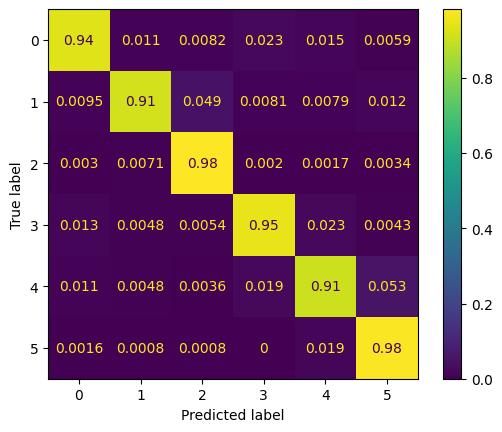

In [ ]:
# train_svm_for_val(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, [0.25], name="balanced_ngram_025")
test_report('final_svm_balanced_ngram_025.joblib', X_test_not_undersampled_ngram, y_test_not_resampled, X_val_not_undersampled_ngram, y_val_not_resampled)

#### Model 2

Validation accuracy:  0.9456096693921081
Test accuracy:  0.9446715587944037
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.967819 | 0.964936 |   0.966375 | 11750        |
| 1            |    0.963117 | 0.954475 |   0.958777 | 13597        |
| 2            |    0.876918 | 0.904073 |   0.890288 |  2971        |
| 3            |    0.938903 | 0.94464  |   0.941763 |  5401        |
| 4            |    0.913063 | 0.912237 |   0.91265  |  4421        |
| 5            |    0.834246 | 0.858407 |   0.846154 |  1243        |
| accuracy     |    0.944672 | 0.944672 |   0.944672 |     0.944672 |
| macro avg    |    0.915678 | 0.923128 |   0.919334 | 39383        |
| weighted avg |    0.94501  | 0.944672 |   0.944811 | 39383        |


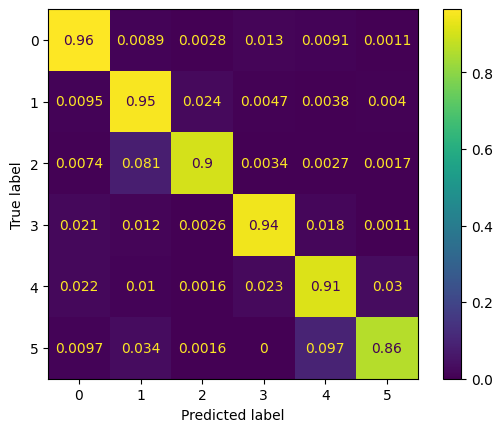

In [ ]:
# train_svm_for_val(X_train_ngram, y_train, X_val_ngram, y_val, [0.25], name="unbalanced_ngram_025", unbalanced=True)
test_report('final_svm_unbalanced_ngram_025.joblib', X_test_ngram, y_test, X_val_ngram, y_val)

### Report test metrics of the two best performing RF

#### Model 3

Validation accuracy:  0.9264130821187344
Test accuracy:  0.9254500672879161
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.97189  | 0.926894 |   0.948859 | 11750       |
| 1            |    0.969512 | 0.912113 |   0.939937 | 13597       |
| 2            |    0.790076 | 0.975429 |   0.873023 |  2971       |
| 3            |    0.907537 | 0.934086 |   0.92062  |  5401       |
| 4            |    0.89515  | 0.901832 |   0.898479 |  4421       |
| 5            |    0.71831  | 0.984714 |   0.830675 |  1243       |
| accuracy     |    0.92545  | 0.92545  |   0.92545  |     0.92545 |
| macro avg    |    0.875413 | 0.939178 |   0.901932 | 39383       |
| weighted avg |    0.93191  | 0.92545  |   0.926799 | 39383       |


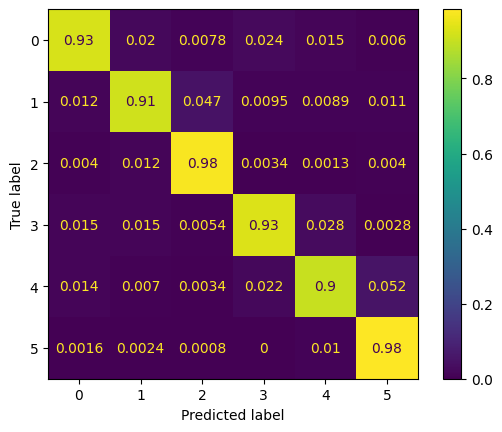

In [ ]:
# trained model previously using:
# train_rf_balanced(X_train_undersampled_ngram, y_train_resampled, X_val_not_undersampled_ngram, y_val_not_resampled, 'ngram_200', num_trees=200)
test_report('random_forest_model_ngram_200.joblib', X_test_not_undersampled_ngram, y_test_not_resampled, X_val_not_undersampled_ngram, y_val_not_resampled)

#### Model 4

Validation accuracy:  0.9218678584124727
Test accuracy:  0.9209811339918239
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.944468 | 0.936511 |   0.940473 | 11750        |
| 1            |    0.913598 | 0.959623 |   0.936045 | 13597        |
| 2            |    0.90191  | 0.826321 |   0.862463 |  2971        |
| 3            |    0.929818 | 0.897797 |   0.913527 |  5401        |
| 4            |    0.902861 | 0.885094 |   0.893889 |  4421        |
| 5            |    0.849873 | 0.806114 |   0.827415 |  1243        |
| accuracy     |    0.920981 | 0.920981 |   0.920981 |     0.920981 |
| macro avg    |    0.907088 | 0.885243 |   0.895635 | 39383        |
| weighted avg |    0.920934 | 0.920981 |   0.920566 | 39383        |


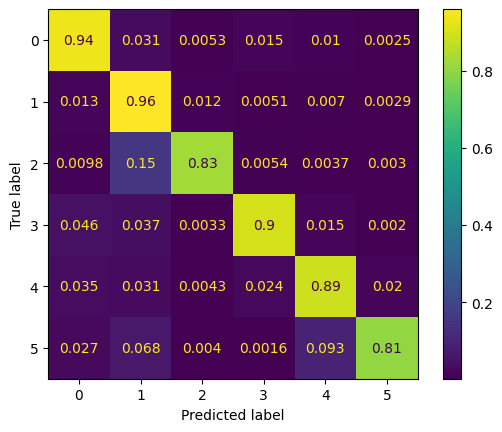

In [ ]:
# Unbalanced dataset, no undersampling, Random Forest With Bootstrap Class Weighting -- X_train_tfidf, y_train
test_report('random_forest_model_tfidf_bcw.joblib', X_test_tfidf, y_test, X_val_tfidf, y_val)

# References

[1] G. Gupta, “Using NLTK for lemmatizing sentences,” Medium. Accessed: Mar. 13, 2024. [Online]. Available: https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258

[2] J. Brownlee, “SMOTE for Imbalanced Classification with Python,” MachineLearningMastery.com. Accessed: Mar. 13, 2024. [Online]. Available: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

[3] J. Brownlee, “Bagging and Random Forest for Imbalanced Classification,” MachineLearningMastery.com. Accessed: Mar. 13, 2024. [Online]. Available: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

[4] “Vectorization Techniques in NLP [Guide].” Accessed: Mar. 13, 2024. [Online]. Available: https://neptune.ai/blog/vectorization-techniques-in-nlp-guide

[5] “4 Sentence Embedding Techniques One Should Know.” Accessed: Mar. 13, 2024. [Online]. Available: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
